# 程序验证

In [6]:
# 导入依赖库
import urllib3
import requests
import os, base64
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

from torch.utils.data import DataLoader

from models import *

from utils.datasets import *
from utils.utils import *

In [7]:
# 获取滑动验证码图像数据
def callback(json):
  return json

response = requests.get(
  "http://captcha.chaoxing.com/captcha/get/verification/image", 
  params = {
    "callback": "callback",
    "captchaId": "42sxgHoTPTKbt0uZxPJ7ssOvtXr3ZgZ1",
  },
  headers = {
  "Referer": "http://office.chaoxing.com/",
 }
)

print(response.text)
data = eval(response.text)
token = data['token']


callback({"token":"06273E5FC2EA11D6060A00C180AEBFC1","imageVerificationVo":{"type":"SLIDE","shadeImage":"/9j/4AAQSkZJRgABAgAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCACrARgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDxxBV+2k2nFUFqxATuBrlZuaobIokdh90kfSo4jxmklNR1GIhbdnJzWlb3kyJtDnF

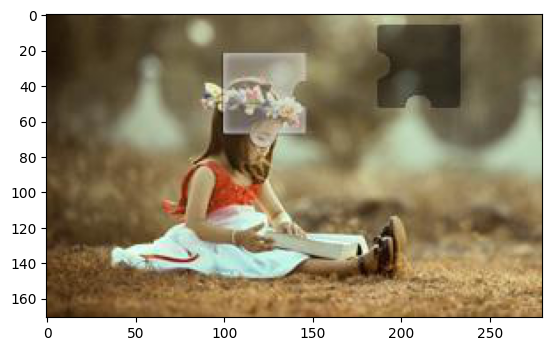

In [8]:
# 处理图像数据成 Image 对象，并打印出
img_data = base64.b64decode(data["imageVerificationVo"]["shadeImage"])
img = Image.open(BytesIO(img_data))
plt.imshow(img)

In [9]:
# YoloV3 配置
model_def_path = "chaoxing_slidecaptcha_verify.cfg"  # 模型定义文件
weights_path   = "chaoxing_slidecaptcha_verify.pth"  # 保存点权重（非结果）

conf_thres     = 0.9  # object confidence threshold （对象置信度）
nms_thres      = 0.4  # iou thresshold for non-maximum suppression
batch_size     = 1    # size of the batches
n_cpu          = 0    # number of cpu threads to use during batch generation
img_size       = 416  # size of each image dimension

origin_img_width = 280
origin_img_height = 171

In [10]:
# 初始化
device = torch.device("cpu") # 选择使用 cpu
# Set up model
model = Darknet(model_def_path, img_size=img_size).to(device)
# Load checkpoint weights
model.load_state_dict(torch.load(weights_path, map_location="cpu"))
# Set in evaluation mode
model.eval()
# Select FloatTensor
Tensor = torch.FloatTensor

In [11]:
# 检测
import time
import datetime

img_tensor = transforms.ToTensor()(img.convert('RGB'))           # 转 tensor 对象
img_tensor_square, _ = pad_to_square(img_tensor, 0)              # Pad to square resolution
img_tensor_resize    = resize(img_tensor_square, img_size)       # resize

dataloader = DataLoader(
    [img_tensor_resize],
    batch_size=batch_size,
    shuffle=False,
    num_workers=n_cpu,
)

prev_time = time.time()

for batch_i, img_tensor in enumerate(dataloader):
    # Configure input
    input_img = Variable(img_tensor.type(Tensor))

    # Get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = non_max_suppression(detections, conf_thres, nms_thres)
        
    # Log progress
    current_time = time.time()
    inference_time = datetime.timedelta(seconds=current_time - prev_time)
    prev_time = current_time
    print("\t+ Batch %d, Inference Time: %s" % (batch_i, inference_time))

    # Get result
    if detections[0] is not None:
        x1 = detections[0][0][0]
        y1 = detections[0][0][1]
        x2 = detections[0][0][2]
        y2 = detections[0][0][3]
        conf = detections[0][0][4]
        cls_conf = detections[0][0][5]
        cls_pred = detections[0][0][6]
    else:
        x1 = 0
        y1 = 0
        x2 = 0
        y2 = 0
        conf = 0
        cls_conf = 0
        cls_conf = 0
        cls_pred = 0
    print(detections)
    print("\t+ Label: %s, Conf: %.5f" % ("target", cls_conf))

	+ Batch 0, Inference Time: 0:00:00.630965
[tensor([[146.0027, 110.6641, 216.1955, 179.6591,   0.9967,   0.9999,   0.0000]])]
	+ Label: target, Conf: 0.99991


0.0 416.0 280
bbox (tensor(98.2711), tensor(20.6393), tensor(47.2452), tensor(46.4390)) offset tensor(98.2711)


<Figure size 640x480 with 0 Axes>

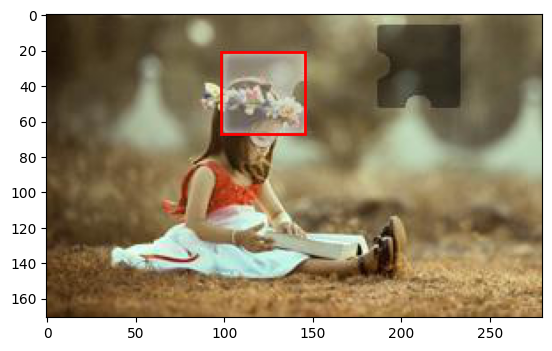

In [12]:
# 显示结果

plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(img)

# Draw bounding boxes and labels of detections
orig_h = origin_img_height
orig_w = origin_img_width

# The amount of padding that was added
pad_x = max(orig_h - orig_w, 0) * (img_size / max(orig_h,orig_w))
pad_y = max(orig_w - orig_h, 0) * (img_size / max(orig_h,orig_w))

# Image height and width after padding is removed
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

# Rescale bounding boxes to dimension of original image
x1 = ((x1 - pad_x // 2) / unpad_w) * orig_w
y1 = ((y1 - pad_y // 2) / unpad_h) * orig_h
x2 = ((x2 - pad_x // 2) / unpad_w) * orig_w
y2 = ((y2 - pad_y // 2) / unpad_h) * orig_h

print(pad_x, unpad_w, orig_w)

# Bounding-box colors
box_w = x2 - x1
box_h = y2 - y1

bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=[1,0,0], facecolor="none")
print('bbox', (x1, y1, box_w, box_h), 'offset', x1)
ax.add_patch(bbox)


In [13]:
# 查看验证结果
x = int(x1) - 5

response = requests.get(
  "http://captcha.chaoxing.com/captcha/check/verification/result", 
  params = {
    "callback": "callback",
    "captchaId": "42sxgHoTPTKbt0uZxPJ7ssOvtXr3ZgZ1",
    "token": token,
    "textClickArr": ('[{{\"x\":{x}}}]').format(x = x),
    "coordinate": "[]",
    "runEnv": "10"
  },
  headers = {
  "Referer": "http://office.chaoxing.com/",
 }
)

print(x)

true  = True
false = False
data = eval(response.text)
print(data)

#validate 有效凭证
if data["result"]:
  validate = eval(data["extraData"])["validate"]

  print("验证成功")
  print({
    "token": token,
    "validate": validate
  })
else:
  print("验证失败")


93
{'error': 0, 'msg': 'ok', 'result': True, 'extraData': '{"validate":"validate_42sxgHoTPTKbt0uZxPJ7ssOvtXr3ZgZ1_06273E5FC2EA11D6060A00C180AEBFC1"}'}
验证成功
{'token': '06273E5FC2EA11D6060A00C180AEBFC1', 'validate': 'validate_42sxgHoTPTKbt0uZxPJ7ssOvtXr3ZgZ1_06273E5FC2EA11D6060A00C180AEBFC1'}
